# Inter-channel interference (ICI) classification using *counting vectors* in a 16 GBd system. 

## Initialization

### Google Colab checking

In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive

    GOOGLE_COLAB = True
    ROOT = "/content/drive/MyDrive/SOFA/ICI_Project"

    drive.mount("/content/drive")
    !cp {ROOT}"/sofa.py" "."
    !cp {ROOT}"/counting_vectors_16f.csv" "."
    !cp {ROOT}"/counting_vectors_16g.csv" "."
else:
    GOOGLE_COLAB = False
    ROOT = "."

### Libraries

In [2]:
import json
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sofa
import tensorflow as tf
import tensorflow.keras as ker
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    multilabel_confusion_matrix,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, models, regularizers, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

2024-01-18 17:06:52.282695: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 17:06:52.353911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 17:06:52.354075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 17:06:52.356810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 17:06:52.368581: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 17:06:52.370439: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
GPU = tf.config.list_physical_devices("GPU")
if len(GPU) > 0:
    print(f"Using GPU: {GPU}")

### Globals

In [4]:
def calc_once(varname, fn, args):
    """Calculate a variable only once."""
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(
            np.intersect1d(
                np.where(lower_limit < array), np.where(array <= upper_limit)
            )
        )

    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull = df_classfull.with_columns(classfull.alias(column_name))

    return df_classfull

def classifier_model(
    layers_props_lst: list, classes_n: int, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """Compile a sequential model for classification purposes."""
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")

    return model


def classification_crossvalidation(
    X, y, X_prod, y_prod, n_splits, layer_props, classes_n, loss_fn, callbacks
):
    """Crossvalidation of a classification network."""
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": [], "prod": []}
    scores["f1"] = {"train": [], "test": [], "prod": []}
    scores["cm"] = {"train": [], "test": [], "prod": []}

    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = classifier_model(layer_props, classes_n, loss_fn, X_train.shape[1])

        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train,
                y_train,
                epochs=5000,
                batch_size=64,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]

        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train, verbose=0)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf, verbose=0)
        # Predict using production values
        fuzzy_predictions_prod = model.predict(X_prod_kf, verbose=0)

        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])
        predictions_prod = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_prod])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": y_train, "Predicted ICI": predictions_train}
        )
        train_data_test = pl.DataFrame(
            {"ICI": y_test, "Predicted ICI": predictions_test}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": y_prod, "Predicted ICI": predictions_prod}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        )
        acc_score_prod = accuracy_score(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            train_data_train["ICI"], train_data_train["Predicted ICI"], average="micro"
        )
        f1_score_test = f1_score(
            train_data_test["ICI"], train_data_test["Predicted ICI"], average="micro"
        )
        f1_score_prod = f1_score(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"], average="micro"
        )

        # RMSE
        cm_score_train = multilabel_confusion_matrix(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        ).tolist()
        cm_score_test = multilabel_confusion_matrix(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        ).tolist()
        cm_score_prod = multilabel_confusion_matrix(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        ).tolist()

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["acc"]["prod"].append(acc_score_prod)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["f1"]["prod"].append(f1_score_prod)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        scores["cm"]["prod"].append(cm_score_prod)

    return scores


def test_classification_model(
    data,
    data_prod,
    n_splits,
    classes_n,
    max_neurons,
    activations,
    use_osnr=True,
    loss_fn="sparse_categorical_crossentropy",
):
    """Test a spectral spacing estimation model with given parameters."""
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Features
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])

    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''} {classes_n} classes")
    callbacks = [
        EarlyStopping(
            monitor="loss", patience=30, mode="min", restore_best_weights=True
        )
    ]

    return classification_crossvalidation(
        X, y, X_prod, y_prod, n_splits, layer_props, classes_n, loss_fn, callbacks
    )

def plot_cm(scores, interval_lst):
    CM = np.array(scores.get("cm").get("test"))
    for n, interval in enumerate(interval_lst):
        result = np.zeros(CM[0][0].shape)
        for cm in CM:
            result = np.add(result, cm[n])
        result /= np.sum(result)
        disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=["Positive", "Negative"])
        disp.plot(colorbar=False)
        lower_limit, upper_limit = interval 
        plt.title(f"Confusion matrix for class from {lower_limit} GHz up to {upper_limit} GHz")
        plt.show()

## FCM

### Load data

In [5]:
if GOOGLE_COLAB:
    cv16f_file = "counting_vectors_16f.csv"
else:
    cv16f_file = "../../Databases/16GBd/counting_vectors_16f.csv"

cv16f = pl.read_csv(cv16f_file, has_header=False, dtypes=[pl.Float64])
# Show the original dataframe
cv16f

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7955,0.1557,0.0309,0.0145,0.0021,0.0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7988,0.1467,0.034,0.0149,0.0035,0.0015,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.789,0.1601,0.0332,0.0132,0.0032,0.0008,0.0002,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7957,0.1542,0.0311,0.0152,0.0024,0.0013,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7947,0.1477,0.0352,0.0143,0.0053,0.0023,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7976,0.152,0.0316,0.0152,0.0031,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7736,0.1619,0.0386,0.0179,0.0039,0.0031,0.0004,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8089,0.1469,0.0293,0.0114,0.0025,0.0009,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8025,0.1523,0.029,0.013,0.0025,0.0005,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [6]:
interval_lst = {"2": [(0, 35), (35, 50)],
                "3": [(0, 32), (32, 35), (35, 50)],
                "4": [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)],
                "5": [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]}

cv16f_class = {}
for classes_n, interval in interval_lst.items():
    cv16f_class[classes_n] = classificator(cv16f, interval, "column_18")
cv16f_class

{'2': shape: (680, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.7955   ┆ 0.1557   ┆ 0.0309   ┆ 0.0145   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.7988   ┆ 0.1467   ┆ 0.034    ┆ 0.0149   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.789    ┆ 0.1601   ┆ 0.0332   ┆ 0.0132   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.7957   ┆ 0.1542   ┆ 0.0311   ┆ 0.0152   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

In [7]:
# Shuffle the dataframe
cv16f_class_shuffled = {}
for classes_n, df in cv16f_class.items():
    cv16f_class_shuffled[classes_n] = df.sample(n=len(df), shuffle=True, seed=1036681523)
cv16f_class_shuffled

{'2': shape: (680, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 0.0       │
 │ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 0.0       │
 │ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

In [8]:
# Extract 10% of the data to use later for "production" testing
cv16f_class_prod = {}
for classes_n, df in cv16f_class_shuffled.items():
    cv16f_class_prod[classes_n] = df[: int(len(df) * 0.1)]
cv16f_class_prod

{'2': shape: (68, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 0.0       │
 │ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 0.0       │
 │ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ 

In [9]:
# Use the rest of the data for normal testing
cv16f_class_new = {}
for classes_n, df in cv16f_class_shuffled.items():
    cv16f_class_new[classes_n] = df[int(len(df) * 0.1) :]
cv16f_class_new

{'2': shape: (612, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.9999   ┆ 0.0001   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 26.3      ┆ 1.0       │
 │ 0.9975   ┆ 0.0024   ┆ 0.0      ┆ 0.0001   ┆ … ┆ 0.0       ┆ 0.0       ┆ 26.3      ┆ 0.0       │
 │ 0.9802   ┆ 0.0193   ┆ 0.0003   ┆ 0.0002   ┆ … ┆ 0.0       ┆ 0.0       ┆ 19.3      ┆ 0.0       │
 │ 0.977    ┆ 0.0214   ┆ 0.0011   ┆ 0.0005   ┆ … ┆ 0.0       ┆ 0.0       ┆ 23.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

### Hyperparameters evaluation

The following hyperparameters are going to be combined and evaluated: 
- Maximum number of neurons in the first layer (8, 16, 32, 64, 128, 256, 512, 1024).
- Number of hidden layers (1, 2, 3).
- Activation functions (ReLu, tanh, sigmoid).
- Using or not the OSNR value as an additional feature.

Results will have the following structure:
```
{"xyz": {"n_neurons": {"osnr": {"classes_n": results}}}}
```
Where `xyz` will be each initial of the activation functions in the model (r for ReLu, t for tanh and s for sigmoid), `n_neurons` will be the maximum number of neurons in the model (corresponding to the first layer), `osnr` will be a string telling if that model used OSNR as input or not (`"osnr"` or `wo_osnr`), then, the number of classes used will be stored.
Finally the results will store the loss history, the serialized model in JSON format in a string and MAE, RMSE and R² values for training, test and production data.

In [10]:
osnr_lst = ["osnr", "wo_osnr"]
max_neurons = [str(2**n) for n in range(3, 11)]
functs = ["relu", "tanh", "sigmoid"]
layers_n = [1, 2, 3]
classes_n = list(map(str, range(2, 6)))

combinations = [
    [list(subset) for subset in product(functs, repeat=n)] for n in layers_n
]

hidden_layers = [item for sublist in combinations for item in sublist]

In [ ]:
try:
    cv16f_class_results = sofa.load_hdf5(f"{ROOT}/cv16f_class_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16f_class_results = defaultdict(
        defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            for n in classes_n:
                args = {
                    "data": cv16f_class_new[n],
                    "data_prod": cv16f_class_prod[n],
                    "n_splits": 5,
                    "classes_n": int(n),
                    "max_neurons": int(neurons),
                    "activations": activations,
                    "use_osnr": True if osnr == "osnr" else False,
                }
                act_fn_name = "".join([s[0] for s in activations])
                if cv16f_class_results[act_fn_name][neurons][osnr][n] == defaultdict():
                    # Get results
                    results = test_classification_model(**args)
                    # Serialize model
                    results["model"] = [
                        utils.serialize_keras_object(model) for model in results["model"]
                    ]
                    # Save serialized model for serialization
                    cv16f_class_results[act_fn_name][neurons][osnr][n] = results
                    # Save results with serialized model
                    print("Saving results...")
                    sofa.save_hdf5(cv16f_class_results, f"{ROOT}/cv16f_class_results.h5", n_backups = 5)
                    print("Results saved!")

Error loading from file, creating a new dictionary
[{'units': 8, 'activation': 'relu'}] + OSNR 2 classes
Needed iterations: 5000
Needed iterations: 2976
Needed iterations: 4082
Needed iterations: 3827
Needed iterations: 2245
Saving results...
Results saved!
[{'units': 8, 'activation': 'relu'}] + OSNR 3 classes
Needed iterations: 4246
Needed iterations: 3141
Needed iterations: 3605
Needed iterations: 4181
Needed iterations: 3375
Saving results...
Results saved!
[{'units': 8, 'activation': 'relu'}] + OSNR 4 classes
Needed iterations: 5000
Needed iterations: 4307
Needed iterations: 3354
Needed iterations: 2174
Needed iterations: 4359
Saving results...
Results saved!
[{'units': 8, 'activation': 'relu'}] + OSNR 5 classes
Needed iterations: 3599
Needed iterations: 3485
Needed iterations: 4346
Needed iterations: 3476


### Results

In [17]:
def get_avg_score(results, target_value, target="neurons", metric="mae", score="test"):
    mae_lst = []
    for activations in hidden_layers:
        if target == "layers" and len(activations) != target_value:
            continue
        for neurons in max_neurons:
            if target == "neurons" and neurons != target_value:
                continue
            for osnr in osnr_lst:
                if target == "osnr" and osnr != target_value:
                    continue
                act_fn_name = "".join([s[0] for s in activations])
                mae_lst.append(
                    np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"])
                )
    return mae_lst

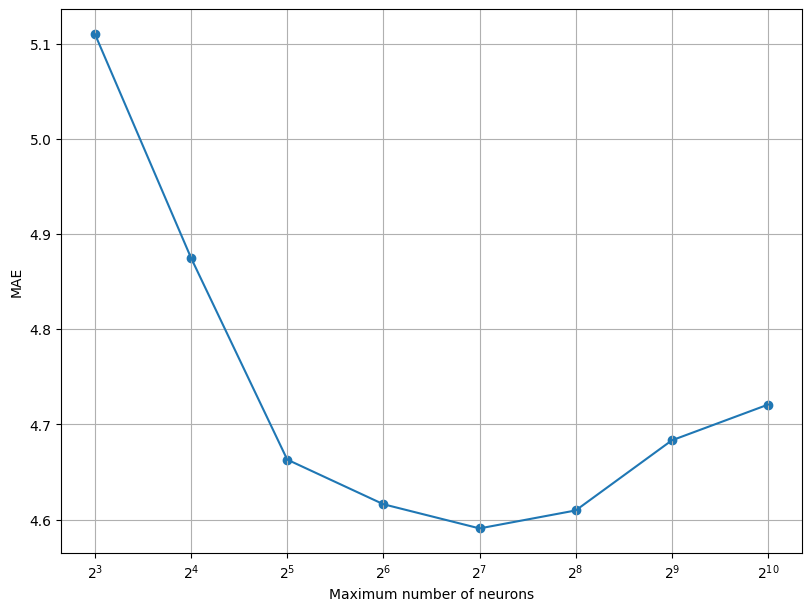

In [18]:
cv16f_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, neurons, target="neurons", metric="mae", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16f_neurons_avg_results, "Maximum number of neurons", log=True)

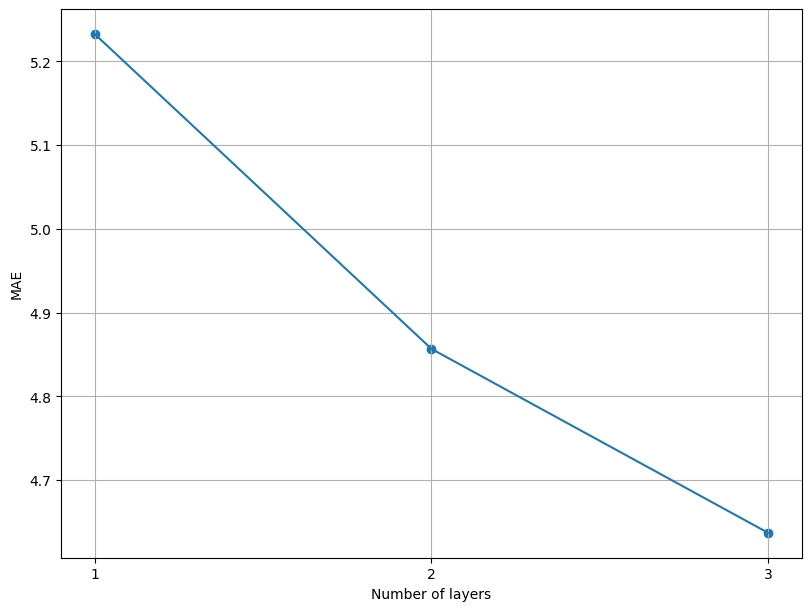

In [19]:
cv16f_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16f_layers_avg_results, "Number of layers", log=False, intx=True)

In [20]:
cv16f_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"With OSNR  Without OSNR")
print(f"{cv16f_osnr_avg_results[0]:.3f}       {cv16f_osnr_avg_results[1]:.3f}")

With OSNR  Without OSNR
4.232       5.235


### Sort models by score

In [21]:
# Find better model by test score
def get_better_models(results, metric="mae", score="test"):
    scores = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                coll = results[act_fn_name][neurons][osnr][metric][score]
                if isinstance(coll, defaultdict):
                    continue
                score_value = np.mean(coll)
                scores.append((score_value, [act_fn_name, neurons, osnr]))
    scores.sort(key=lambda x: x[0])
    return pl.dataframe.DataFrame(scores)

In [22]:
cv16f_better_models_df = get_better_models(
    cv16f_reg_results, metric="mae", score="test"
)
cv16f_better_models_df.head(10)

column_0,column_1
f64,list[str]
2.80612,"[""tst"", ""512"", ""osnr""]"
2.807177,"[""tss"", ""32"", ""osnr""]"
2.818996,"[""stt"", ""256"", ""osnr""]"
2.83914,"[""tss"", ""256"", ""osnr""]"
2.845752,"[""tst"", ""128"", ""osnr""]"
2.879023,"[""rtt"", ""256"", ""osnr""]"
2.881343,"[""tss"", ""64"", ""osnr""]"
2.891847,"[""tss"", ""1024"", ""osnr""]"
2.893098,"[""rrs"", ""256"", ""osnr""]"


## GKM

In [23]:
if GOOGLE_COLAB:
    cv16g_file = "counting_vectors_16g.csv"
else:
    cv16g_file = "../../Databases/16GBd/counting_vectors_16g.csv"

cv16g = pl.read_csv(cv16g_file, has_header=False, dtypes=[pl.Float64])
# Show the original dataframe
cv16g

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7904,0.1593,0.0307,0.0155,0.0028,0.0011,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,16.3,15.5
0.7958,0.1501,0.0311,0.0169,0.0036,0.0019,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7867,0.1636,0.0306,0.0149,0.0026,0.0012,0.0002,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7893,0.1616,0.0285,0.0164,0.0021,0.0019,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7918,0.1496,0.0331,0.0175,0.0055,0.002,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7948,0.1564,0.029,0.017,0.0023,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7682,0.1669,0.0362,0.0205,0.0044,0.0028,0.0005,0.0003,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8038,0.1516,0.0279,0.0132,0.002,0.0011,0.0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8013,0.1537,0.029,0.0125,0.0024,0.0009,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [24]:
# Shuffle the dataframe
cv16g_shuffled = cv16g.sample(n=len(cv16g), shuffle=True, seed=1036681523)
cv16g_shuffled

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.8876,0.0925,0.0125,0.0061,0.0006,0.0006,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.3,15.5
0.883,0.1012,0.0108,0.0048,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,17.0
0.87,0.1126,0.0122,0.0049,0.0001,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,16.0
0.999,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.3,17.0
0.8279,0.1351,0.0211,0.0104,0.0029,0.0022,0.0003,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,16.0
0.9184,0.0743,0.0054,0.0017,0.0001,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,17.6
0.9417,0.0545,0.003,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,50.0
0.9785,0.0207,0.0007,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.3,17.6
0.9992,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.3,17.6


In [25]:
# Extract 10% of the data to use later for "production" testing
cv16g_prod = cv16g_shuffled[: int(len(cv16g_shuffled) * 0.1)]
cv16g_prod

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.8876,0.0925,0.0125,0.0061,0.0006,0.0006,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.3,15.5
0.883,0.1012,0.0108,0.0048,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,17.0
0.87,0.1126,0.0122,0.0049,0.0001,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,16.0
0.999,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.3,17.0
0.8279,0.1351,0.0211,0.0104,0.0029,0.0022,0.0003,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,16.0
0.9184,0.0743,0.0054,0.0017,0.0001,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,17.6
0.9417,0.0545,0.003,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,50.0
0.9785,0.0207,0.0007,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.3,17.6
0.9992,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.3,17.6


In [26]:
# Use the rest of the data for normal testing
cv16g_new = cv16g_shuffled[int(len(cv16g_shuffled) * 0.1) :]

### Hyperparameters evaluation

In [28]:
try:
    cv16g_reg_results = sofa.load_hdf5(f"{ROOT}/cv16g_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16g_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": cv16g_new,
                "data_prod": cv16g_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if cv16g_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                cv16g_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16g_reg_results, f"{ROOT}/cv16g_reg_results.h5")
                print("Results saved!")

### Results

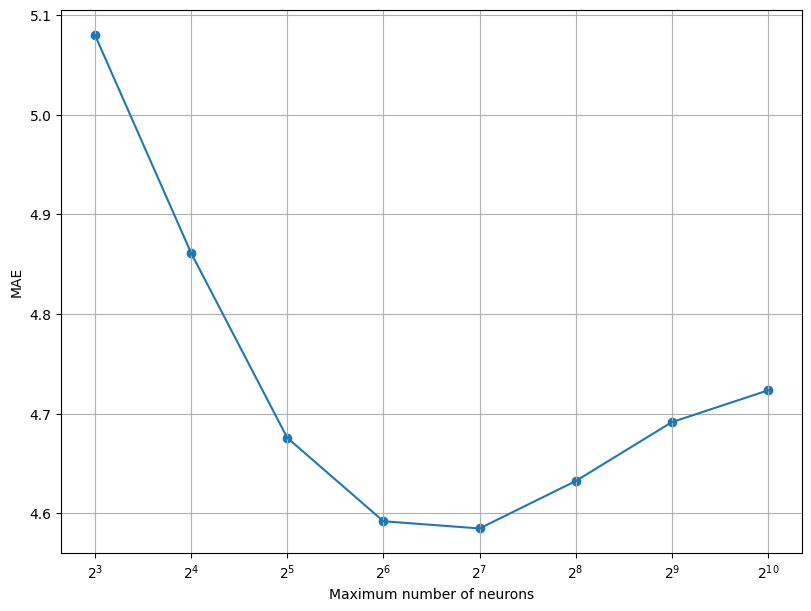

In [29]:
cv16g_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, neurons, target="neurons", metric="mae", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16g_neurons_avg_results, "Maximum number of neurons", log=True)

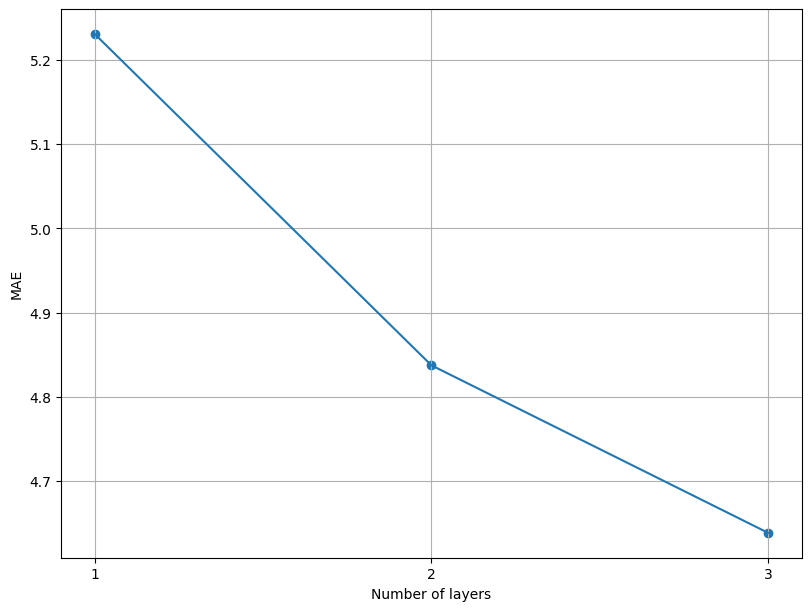

In [30]:
cv16g_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16g_layers_avg_results, "Number of layers", log=False, intx=True)

In [31]:
cv16g_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"Con OSNR  Sin OSNR")
print(f"{cv16g_osnr_avg_results[0]:.3f}       {cv16g_osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
4.232       5.228


### Sort models by score

In [32]:
cv16g_better_models_df = get_better_models(
    cv16g_reg_results, metric="mae", score="test"
)
cv16g_better_models_df.head(10)

column_0,column_1
f64,list[str]
2.756541,"[""tst"", ""128"", ""osnr""]"
2.822385,"[""tst"", ""64"", ""osnr""]"
2.830602,"[""rtt"", ""64"", ""osnr""]"
2.837135,"[""tss"", ""64"", ""osnr""]"
2.842542,"[""rss"", ""32"", ""osnr""]"
2.852606,"[""rtt"", ""512"", ""osnr""]"
2.871675,"[""rst"", ""128"", ""osnr""]"
2.873786,"[""tst"", ""512"", ""osnr""]"
2.886047,"[""rrs"", ""256"", ""osnr""]"
